In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta
from matplotlib import pyplot as plt

# Probability of sharing distribution


## Description of the model and the data

They consider two groups, $A$ and $B$, and two campaigns (which are roughly equivalent to our articles $a$ and $b$).

Articles $a$ and $b$ propagate independently of each other: $u_2$ shares article $a$ with probability $p_A$, given that $u_1$ shared it. Analogously, $u_2$ shares article $b$ with probability $p_B$, given that $u_1$ shared it.

They model the spread of information with a graph where a subset of the nodes are seeded with the information.

In this dataset, the graph is the Twitter's follower graph (an edge conveys that $u_2$ follows $u_1$). The dataset also contains the probabilities $p_A$ and $p_B$.

We only know the group for the seeds in the graph.

We perform the analysis for the following datasets in the dataset of "*Balancing Information Exposure in Social Networks*".

- [uselections](#uselections)
- [brexit](#brexit)
- [abortion](#abortion)
- [obamacare](#obamacare)

## uselections

In [86]:
# load seeds
A = [l.strip() for l in open("uselections/side1_seeds.txt").readlines()]  # A = pro Hillary
B = [l.strip() for l in open("uselections/side2_seeds.txt").readlines()]  # B = pro Trump
len(A), len(B)

(85, 99)

In [87]:
# load probabilities
df = pd.read_csv("uselections/uselections_network_heterogeneous.txt", sep='\t', names=['User1', 'User2', 'pA', 'pB'])
df

,User1,User2,pA,pB
0,003a04f8c2054b7,birdonachair,0.000834,0.008674
1,003a04f8c2054b7,patriot18d,0.001160,0.003320
2,003a04f8c2054b7,pamela_moore13,0.000143,0.004143
3,003a04f8c2054b7,jbaker31826004,0.000604,0.015884
4,003a04f8c2054b7,glucklichschon,0.001960,0.019880
...,...,...,...,...
845147,healthyyoga07,rickrwells,0.000250,0.010810
845148,healthyyoga07,supercos7,0.004560,0.015920
845149,healthyyoga07,ladiesfortrump,0.001448,0.032888
845150,healthyyoga07,usa_with_trump,0.001067,0.016427


#### Issues with the dataset:

In [89]:
df.groupby('User2').std().sort_values('pA', ascending=False)

,pA,pB
User2,,
003a04f8c2054b7,0.0,0.0
ohiorepubmom,0.0,0.0
officecandy,0.0,0.0
officialtrumpil,0.0,0.0
offthemenu67,0.0,0.0
...,...,...
zoso418,NaN,NaN
ztrak5050,NaN,NaN
zuivercor,NaN,NaN


Surprisingly, there is zero variance in the probabilities of sharing within a follower (if we fix User2 all the probabilities are the same). This is strange because to estimate these probabilities they divide posts that $u_2$ shared from $u_1$ divided by total posts shared by $u_2$. This would imply that all users shared the same number of posts from the people they follow!?

I opened an issue in their GitHub:

https://github.com/gvrkiran/BalancedExposure/issues/1

### Homophily

We measure homophily by estimating the probabilities that a user that belongs to group $g$ follows a user in group $g'$. This is very close to our replacement model because if $u_1$ shares content, it gives the opportunity to $u_2$ (the follower) to retweet the content.

In [16]:
# membership
labeled = df[(df.User1.isin(A) | df.User1.isin(B)) & (df.User2.isin(A) | df.User2.isin(B))].copy()
labeled['Group1'] = labeled.User1.isin(A).replace({True: 'A', False: 'B'})
labeled['Group2'] = labeled.User2.isin(A).replace({True: 'A', False: 'B'})
labeled.head()

,User1,User2,pA,pB,Group1,Group2
3282,1boxingking1,georgemason101,0.003017,0.082857,B,B
6861,20donaldtrump16,azz_amis,0.006907,0.086667,B,B
6865,20donaldtrump16,tukinovf,0.002937,0.082857,B,B
6870,20donaldtrump16,ronyerby,0.004160,0.084000,B,B
11871,6f1abe900f56450,honey17011,0.065718,0.000518,A,A


In [17]:
labeled.Group1.value_counts(normalize=True).rename("$\\pi$").reset_index()

,index,$\pi$
0,A,0.554237
1,B,0.445763



To estimate the $q$ probabilities we just count the number of edges for each combination of groups and calculate group frequencies.

In [18]:
# replacement counts
replacements = (labeled.groupby(['Group1', 'Group2']).User1
                       .count()
                       .unstack(fill_value=0)
                       .stack()
                       .rename('Counts')
                       .reset_index()
                       .set_index(['Group1', 'Group2']))
replacements

Counts
Group1 Group2        
A      A          323
       B            4
B      A            0
       B          263

In [19]:
# group1 counts
groups = (labeled.groupby('Group1').User1
                 .count()
                 .rename('Counts')
                 .reset_index()
                 .set_index('Group1'))
groups

,Counts
Group1,
A,327
B,263


In [21]:
qs = (replacements / groups).rename(columns={'Counts': 'Frequency ($q$)'})
qs

Frequency ($q$)
Group1 Group2                 
A      A              0.987768
       B              0.012232
B      A              0.000000
       B              1.000000

The following is the homophily matrix (coordinates are the $q_A$, $1-q_A$, and 1- $q_B$, $q_B$ probabilities):

In [22]:
qs.unstack().values

array([[0.98776758, 0.01223242],
       [0.        , 1.        ]])

### Share probability distributions


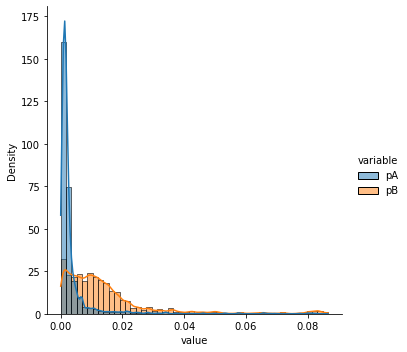

In [9]:
sns.displot(data=pd.melt(df,
                         id_vars=['User1', 'User2'],
                         value_vars=['pA', 'pB']),
            x='value',
            hue='variable',
            bins=50, kde=True, stat='density')

The pro-Trump distribution ($p_B$) is less skewed, meaning that pro-Trump tweets are more likely to be retweeted.

Since this is a distribution of probabilities, it should have support on $[0,1]$. A beta distribution may be a good choice to fit the data.

In [10]:
# MLE estimates for the parameters of the beta distribution (for p_A)
a1, b1, loc1, scale1 = beta.fit(df.pA, floc=0, fscale=1)
a1, b1

(0.7961640748261505, 222.62377495491623)

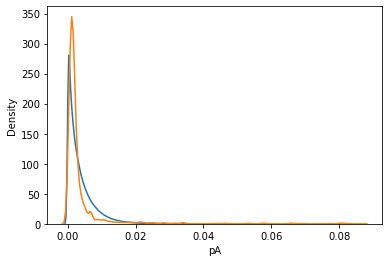

In [11]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=df.pA.shape[0]))
sns.kdeplot(df.pA)

In [12]:
# MLE estimates for the parameters of the beta distribution (for p_B)
a2, b2, loc2, scale2 = beta.fit(df.pB, floc=0, fscale=1)
a2, b2

(1.0402128477517107, 71.47304220053908)

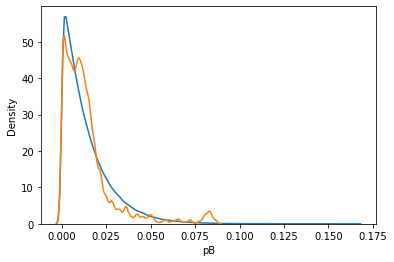

In [13]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=df.pB.shape[0]))
sns.kdeplot(df.pB)

The probabilities above are the conditional probabilities on a given initiator. In the data we see that the probability of sharing is independent of the initiator. That's strange because, in practice, since reputation and credibility are important factors for sharing someone else's tweet.

### Different groups

Ideally, we would like to study the distributions of $p_{A, s}$ and $p_{B, s}$ for $s\in\{a,b\}$ and not just the marginal probabilities $p_{*, a}$ and $p_{*,b}$ (which are the probabilities of clicking on the articles regardless of group membership).

In [15]:
dfg = df[df.User2.isin(B) | df.User2.isin(A)]  # we just care about the group of the user who is retweeting

In [16]:
group = dfg.User2.isin(A).replace({True: 'A', False: 'B'})

In [17]:
dfg.groupby(group).User2.count()

User2
A    6692
B    8765
Name: User2, dtype: int64

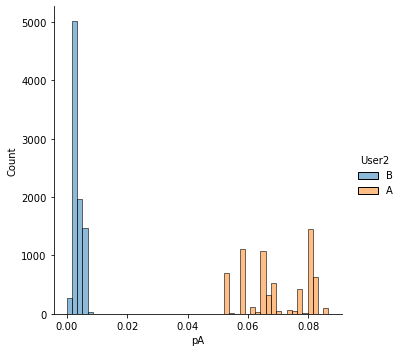

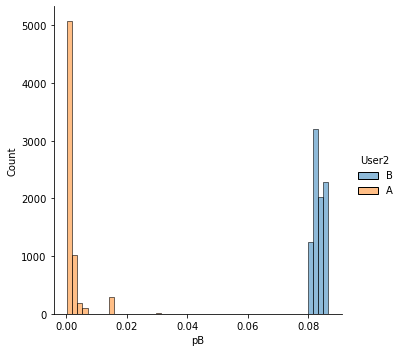

In [18]:
sns.displot(data=dfg, x='pA', hue=group, bins=50)
sns.displot(data=dfg, x='pB', hue=group, bins=50)

This symmetry makes sense because the probability of sharing the article that agrees with the group's views is higher than otherwise.

#### Fitting the distribution of $p_{A,a}$

In [19]:
# MLE estimates for the parameters of the beta distribution (for $p_{A,a}$)
a1, b1, loc1, scale1 = beta.fit(dfg[group == 'A'].pA, floc=0, fscale=1)
a1, b1

(41.45784070052453, 556.8653671739492)

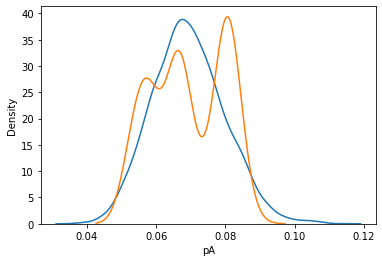

In [20]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=dfg[group == 'A'].pA.shape[0]))
sns.kdeplot(dfg[group == 'A'].pA, bw_adjust=2)

#### Fitting the distribution of $p_{A,b}$

In [21]:
a2, b2, loc2, scale2 = beta.fit(dfg[group == 'A'].pB, floc=0, fscale=1)
a2, b2

(0.7519296311195025, 413.4664888783973)

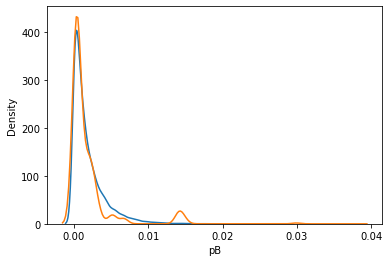

In [22]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=dfg[group == 'A'].pB.shape[0]))
sns.kdeplot(dfg[group == 'A'].pB)

#### Fitting the distribution of $p_{B,a}$

In [23]:
a3, b3, loc3, scale3 = beta.fit(dfg[group == 'B'].pA, floc=0, fscale=1)
a3, b3

(6.096475779403813, 1519.8459882514462)

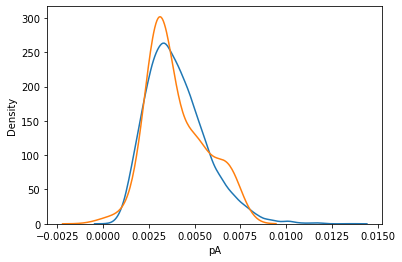

In [24]:
sns.kdeplot(np.random.beta(a=a3, b=b3, size=dfg[group == 'B'].pA.shape[0]))
sns.kdeplot(dfg[group == 'B'].pA, bw_adjust=3)

#### Fitting the distribution of $p_{B,b}$

In [25]:
a4, b4, loc4, scale4 = beta.fit(dfg[group == 'B'].pB, floc=0, fscale=1)
a4, b4

(2152.960173995409, 23647.671142918956)

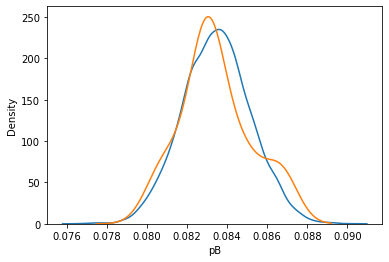

In [26]:
sns.kdeplot(np.random.beta(a=a4, b=b4, size=dfg[group == 'B'].pB.shape[0]))
sns.kdeplot(dfg[group == 'B'].pB, bw_adjust=3)

In [27]:
# TODO: perhaps we should perform some goodness-of-fit tests

## brexit

In [24]:
# load seeds
A = [l.strip() for l in open("brexit/side1_seeds.txt").readlines()]  # A = pro Hillary
B = [l.strip() for l in open("brexit/side2_seeds.txt").readlines()]  # B = pro Trump
len(A), len(B)

(60, 94)

In [28]:
# load probabilities
df = pd.read_csv("brexit/brexit_network_heterogeneous.txt", sep='\t', names=['User1', 'User2', 'pA', 'pB'])
df

,User1,User2,pA,pB
0,007harvey,spanks69,3.200200e-04,9.600200e-04
1,007harvey,leon19070210,1.440020e-03,1.200002e-02
2,007harvey,kiwikafir,9.600200e-04,2.400020e-03
3,007harvey,countryboylife,4.800200e-04,2.000000e-08
4,007harvey,izzydos,2.000000e-08,2.000000e-08
...,...,...,...,...
48825,leavehq,stop_the_eu,4.800200e-04,8.000002e-02
48826,leavehq,andreww01447528,3.200200e-04,3.200020e-03
48827,leavehq,karrider,2.000000e-08,2.000000e-08
48828,leavehq,peter_woods,5.280020e-03,6.432002e-02


In [85]:
df.groupby('User2').std().sort_values('pA', ascending=False).head(n=30)

,pA,pB
User2,,
damar2009smart,0.021213,0.021213
mrsmacca80,0.019245,0.019245
biggixer,0.015000,0.015000
spannishchicken,0.014142,0.014142
luxbitcoin,0.014142,0.014142
rottipotty,0.014142,0.014142
destinyvcourage,0.014142,0.014142
joemoranuol,0.014142,0.014142
jnsn69,0.014142,0.014142


It seems that this dataset does not have the issue we found in the uselections dataset.

### Homophily

We measure homophily by estimating the probabilities that a user that belongs to group $g$ follows a user in group $g'$. This is very close to our replacement model because if $u_1$ shares content, it gives the opportunity to $u_2$ (the follower) to retweet the content.

In [29]:
# membership
labeled = df[(df.User1.isin(A) | df.User1.isin(B)) & (df.User2.isin(A) | df.User2.isin(B))].copy()
labeled['Group1'] = labeled.User1.isin(A).replace({True: 'A', False: 'B'})
labeled['Group2'] = labeled.User2.isin(A).replace({True: 'A', False: 'B'})
labeled.head()

,User1,User2,pA,pB,Group1,Group2
1328,_ilbtm,steven_winstone,0.01104,0.00592,A,A
1329,_ilbtm,sj_powell,0.01856,0.08000,A,A
1333,_ilbtm,politicssense,0.01200,0.01312,A,A
1341,_ilbtm,theordinaryman2,0.08000,0.08000,A,A
1346,_ilbtm,stop_the_eu,0.00048,0.08000,A,B


In [30]:
labeled.Group1.value_counts(normalize=True).rename("$\\pi$").reset_index()

,index,$\pi$
0,A,0.524684
1,B,0.475316



To estimate the $q$ probabilities we just count the number of edges for each combination of groups and calculate group frequencies.

In [31]:
# replacement counts
replacements = (labeled.groupby(['Group1', 'Group2']).User1
                       .count()
                       .unstack(fill_value=0)
                       .stack()
                       .rename('Counts')
                       .reset_index()
                       .set_index(['Group1', 'Group2']))
replacements

Counts
Group1 Group2        
A      A          311
       B          146
B      A          255
       B          159

In [32]:
# group1 counts
groups = (labeled.groupby('Group1').User1
                 .count()
                 .rename('Counts')
                 .reset_index()
                 .set_index('Group1'))
groups

,Counts
Group1,
A,457
B,414


In [33]:
qs = (replacements / groups).rename(columns={'Counts': 'Frequency ($q$)'})
qs

Frequency ($q$)
Group1 Group2                 
A      A              0.680525
       B              0.319475
B      A              0.615942
       B              0.384058

The following is the homophily matrix (coordinates are the $q_A$, $1-q_A$, and 1- $q_B$, $q_B$ probabilities):

In [34]:
qs.unstack().values

array([[0.68052516, 0.31947484],
       [0.61594203, 0.38405797]])

### Share probability distributions


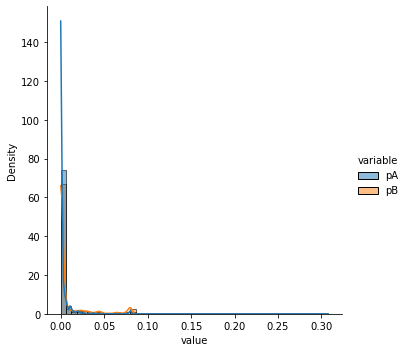

In [47]:
sns.displot(data=pd.melt(df,
                         id_vars=['User1', 'User2'],
                         value_vars=['pA', 'pB']),
            x='value',
            hue='variable',
            bins=50, kde=True, stat='density')

In comparison to the uselections dataset, in brexit both sharing distributions are very skewed.

Since this is a distribution of probabilities, it should have support on $[0,1]$. A beta distribution may be a good choice to fit the data.

In [48]:
# MLE estimates for the parameters of the beta distribution (for p_A)
a1, b1, loc1, scale1 = beta.fit(df.pA, floc=0, fscale=1)
a1, b1

(0.12045986525314124, 51.07492424881336)

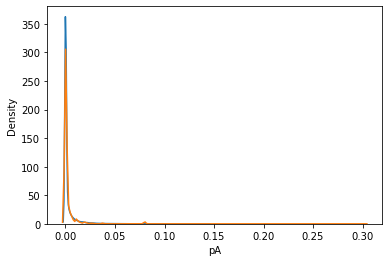

In [49]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=df.pA.shape[0]))
sns.kdeplot(df.pA)

In [50]:
# MLE estimates for the parameters of the beta distribution (for p_B)
a2, b2, loc2, scale2 = beta.fit(df.pB, floc=0, fscale=1)
a2, b2

(0.11460151200225399, 14.595024591908238)

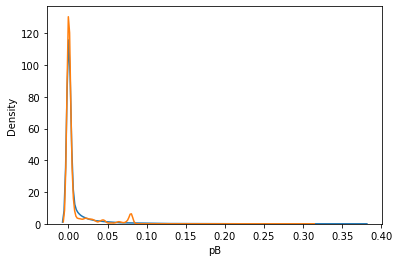

In [51]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=df.pB.shape[0]))
sns.kdeplot(df.pB)

The probabilities above are the conditional probabilities on a given initiator. In the data we see that the probability of sharing is independent of the initiator. That's strange because, in practice, since reputation and credibility are important factors for sharing someone else's tweet.

### Different groups

Ideally, we would like to study the distributions of $p_{A, s}$ and $p_{B, s}$ for $s\in\{a,b\}$ and not just the marginal probabilities $p_{*, a}$ and $p_{*,b}$ (which are the probabilities of clicking on the articles regardless of group membership).

In [52]:
dfg = df[df.User2.isin(B) | df.User2.isin(A)]  # we just care about the group of the user who is retweeting

In [53]:
group = dfg.User2.isin(A).replace({True: 'A', False: 'B'})

In [54]:
dfg.groupby(group).User2.count()

User2
A    3008
B    1392
Name: User2, dtype: int64

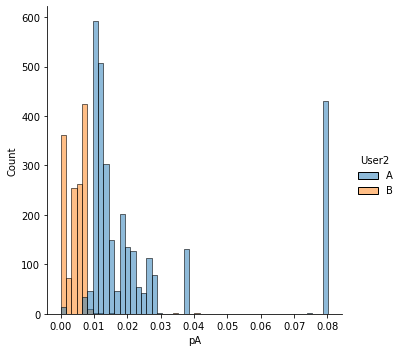

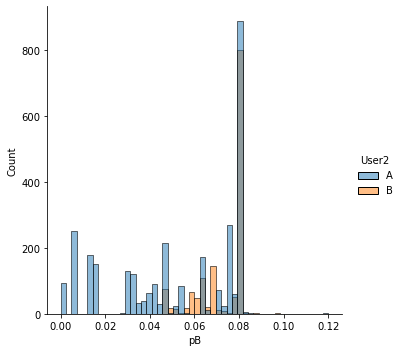

In [55]:
sns.displot(data=dfg, x='pA', hue=group, bins=50)
sns.displot(data=dfg, x='pB', hue=group, bins=50)

This symmetry makes sense because the probability of sharing the article that agrees with the group's views is higher than otherwise.

#### Fitting the distribution of $p_{A,a}$

In [56]:
# MLE estimates for the parameters of the beta distribution (for $p_{A,a}$)
a1, b1, loc1, scale1 = beta.fit(dfg[group == 'A'].pA, floc=0, fscale=1)
a1, b1

(1.6421893317945877, 62.9176081976947)

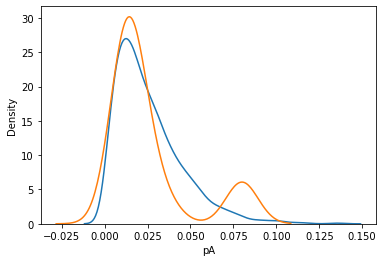

In [57]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=dfg[group == 'A'].pA.shape[0]))
sns.kdeplot(dfg[group == 'A'].pA, bw_adjust=2)

#### Fitting the distribution of $p_{A,b}$

In [58]:
a2, b2, loc2, scale2 = beta.fit(dfg[group == 'A'].pB, floc=0, fscale=1)
a2, b2

(1.4779704026249152, 27.402822213177515)

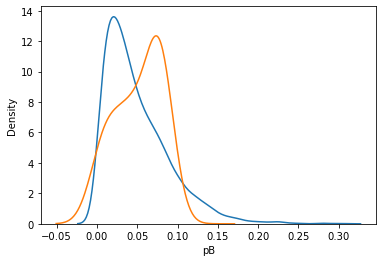

In [74]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=dfg[group == 'A'].pB.shape[0]))
sns.kdeplot(dfg[group == 'A'].pB, bw_adjust=3)

#### Fitting the distribution of $p_{B,a}$

In [67]:
a3, b3, loc3, scale3 = beta.fit(dfg[group == 'B'].pA, floc=0, fscale=1)
a3, b3

(1.7187375537951832, 380.1479381108044)

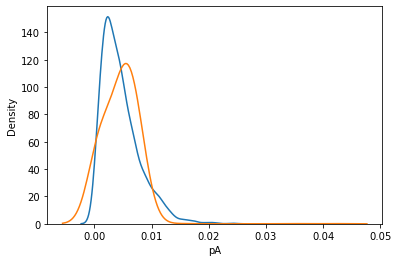

In [68]:
sns.kdeplot(np.random.beta(a=a3, b=b3, size=dfg[group == 'B'].pA.shape[0]))
sns.kdeplot(dfg[group == 'B'].pA, bw_adjust=3)

#### Fitting the distribution of $p_{B,b}$

In [69]:
a4, b4, loc4, scale4 = beta.fit(dfg[group == 'B'].pB, floc=0, fscale=1)
a4, b4

(39.62421666552372, 506.9074863422272)

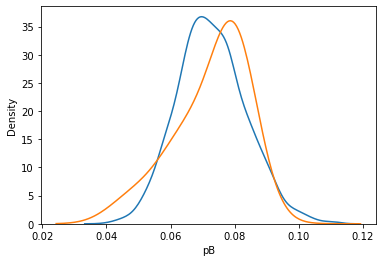

In [73]:
sns.kdeplot(np.random.beta(a=a4, b=b4, size=dfg[group == 'B'].pB.shape[0]))
sns.kdeplot(dfg[group == 'B'].pB, bw_adjust=3)